Modify residual to attempt enforcing periodicity conditions.
The ansatz now sets G(x)=1, D(x)=x. This is to enforce u(0)=1, so that there is a unique solution for the initial condition giving rise to a given period. 

In [1]:
from sympy import init_printing
init_printing(use_latex=True) 

from math import floor
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.misc.optimizers import adam
from functools import reduce

from reusable_functions import init_random_params, neural_net_predict, modded_basinhopping

In [2]:
#Problem Setup: 
#Make sure the residual and forcing functions correspond to your ODE.
#Note the change in the loss function to add periodicity

c=0.;
k=1.;
T=2*3.14159265;
forcing_fn = lambda x: 0.
layer_sizes=[1,10,10,1]
nx=100
u_0=1.; #initial position
v_0=1.; #initial velocity
G=lambda x:0 #to satisfy BCs
#D=lambda x:x**2 #distance function
#D=lambda x:x*(8-x) #distance function
D=lambda x:x #distance function
x_space = np.linspace(0, 7, nx)
T_idx_diff=floor(T/7*nx)

def u(params, x):
    return G(x)+D(x)*neural_net_predict(params, x)


du=grad(u,1)
du2=grad(du,1)

def resid(params, x): 
    return np.square(du2(params,x)+c*du(params,x)+k*u(params,x)-forcing_fn(x))
def resid_batch(params, x_batch):
    resid_temp=list(map(lambda x: resid(params, x)**2, x_batch))
    resid_sum=reduce(lambda x,y:x+y, resid_temp)
    return resid_sum/len(x_batch)  
def periodicity_err(params):
    sln=[u(params, x) for x in x_space]
    err=[(sln[i]-sln[i-T_idx_diff])**2 for i in range(T_idx_diff, len(x_space))]
    err_sum=reduce(lambda x,y:x+y, err)
    return err_sum/len(err)
def loss_function(params):
    return periodicity_err(params)+resid_batch(params, x_space)

In [3]:
loss_grad=grad(loss_function)

x0=init_random_params(1, layer_sizes)
optimized_params, fun=modded_basinhopping(loss_function, loss_grad,x0, num_iter=0, max_bfgs_iter=800, ftol=10e-13)

/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Start basinhopping.Current func val:[107.78510297]
Basinhopping fun: f(x) = [3.49651639e-06]
Call fun itself: [3.49651639e-06]


Text(0.5, 1.0, 'phase portrait')

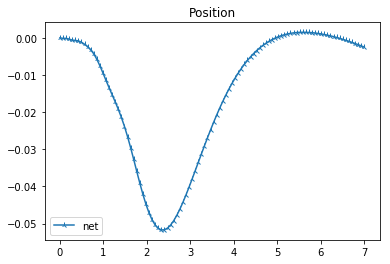

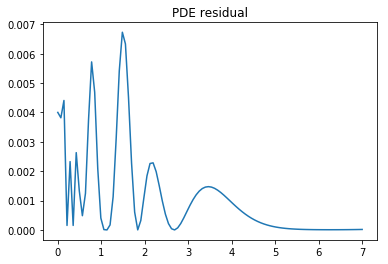

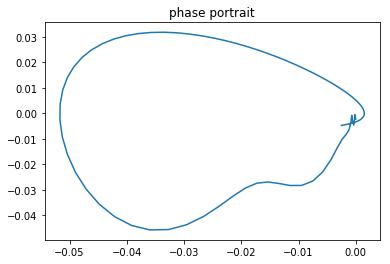

In [4]:
plt.figure
plt.clf()
ax=plt.gca()

sln = np.zeros(nx)

for i,x in enumerate(x_space):
    sln[i]=u(optimized_params, x)

plt.plot(x_space, sln, label='net', marker='2')
plt.title("Position")
ax.legend()

    
plt.figure()
pde_err=np.zeros(x_space.shape)
for i, x in enumerate(x_space):
    pde_err[i]=resid(optimized_params, x)

plt.plot(x_space, pde_err, label='error')
plt.title('PDE residual')

pos=np.zeros(x_space.shape)
vel=np.zeros(x_space.shape)

plt.figure()
for i, x in enumerate(x_space):
    pos[i]=u(optimized_params, x)
    vel[i]=du(optimized_params, x)
plt.plot(pos, vel, label='phase plot')
plt.title('phase portrait')